In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np


In [ ]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Scale pixel values to range [0, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X.shape

(70000, 784)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to range [-1, 1]
])


In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 247540777.26it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34709367.86it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 1655034.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6729257.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Train the model
epochs = 30
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")


Epoch 1, Loss: 0.40559749093168834
Epoch 2, Loss: 0.2001341282507218
Epoch 3, Loss: 0.14069757072914288
Epoch 4, Loss: 0.11525536173168244
Epoch 5, Loss: 0.09623470323096746
Epoch 6, Loss: 0.08368982270614171
Epoch 7, Loss: 0.07633204010850403
Epoch 8, Loss: 0.0661246484832596
Epoch 9, Loss: 0.058913884777526085
Epoch 10, Loss: 0.05623054807086779
Epoch 11, Loss: 0.050752112825117164
Epoch 12, Loss: 0.04539620519309406
Epoch 13, Loss: 0.044228354596030486
Epoch 14, Loss: 0.0387768439667077
Epoch 15, Loss: 0.03887579152634221
Epoch 16, Loss: 0.03608063611499868
Epoch 17, Loss: 0.034905224576031964
Epoch 18, Loss: 0.030098939153032803
Epoch 19, Loss: 0.02998526358012252
Epoch 20, Loss: 0.026762849523901264
Epoch 21, Loss: 0.02791841687752073
Epoch 22, Loss: 0.02369940979584646
Epoch 23, Loss: 0.026972709831217048
Epoch 24, Loss: 0.02331079753090067


KeyboardInterrupt: 

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)


In [ ]:
# Train and evaluate logistic regression
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Train and evaluate random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
predicted_rf = rf.predict(X_test)



In [ ]:
y_test_np = labels.numpy()
predicted_mlp_np = predicted.numpy()


In [ ]:
f1_mlp = f1_score(y_test_np, predicted_mlp_np, average='macro')

# Calculate F1-score for logistic regression
f1_lr = f1_score(y_test, predicted_lr, average='macro')

# Calculate F1-score for random forest
f1_rf = f1_score(y_test, predicted_rf, average='macro')

print("F1-score (MLP):", f1_mlp)
print("F1-score (Logistic Regression):", f1_lr)
print("F1-score (Random Forest):", f1_rf)



F1-score (MLP): 0.9740749568454656
F1-score (Logistic Regression): 0.9207477462662104
F1-score (Random Forest): 0.9685196043059751


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [ ]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


labels = ['0', '1', '2','3','4','5','6','7','8','9']


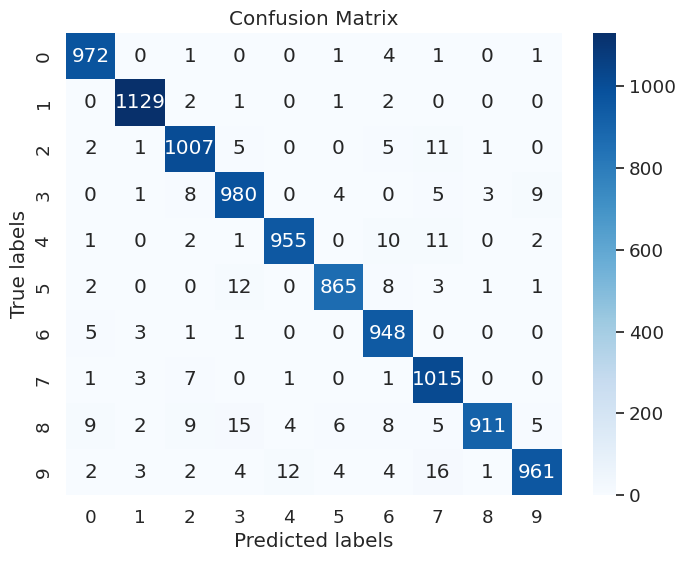

In [ ]:
conf_matrix_mlp = confusion_matrix(y_test_np, predicted_mlp_np)
plot_confusion_matrix(conf_matrix_mlp, labels)


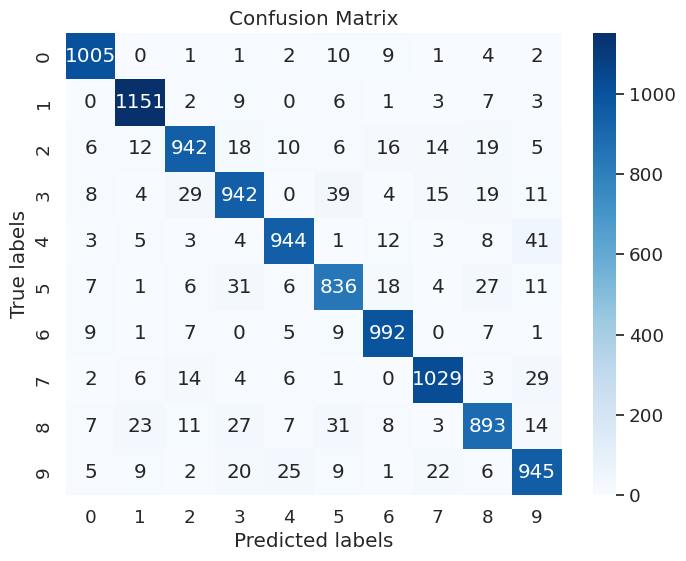

In [ ]:
conf_matrix_lr = confusion_matrix(y_test, predicted_lr)
plot_confusion_matrix(conf_matrix_lr, labels)


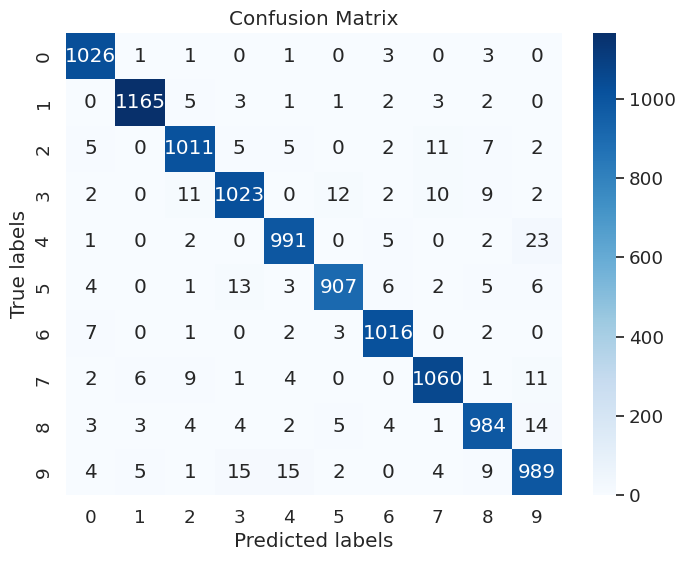

In [ ]:
conf_matrix_rf = confusion_matrix(y_test, predicted_rf)
plot_confusion_matrix(conf_matrix_rf, labels)


We can clearly observe 7 and 9 are getting confused significantly. Also numbers like 4 and 9, 8 and 3, 2 and 7, 4 and 7 are getting confused

We can clearly observe significant differneces in results between linear regression and mlp. There was not significant differnece between mlp and rf, this is because we are reaching at a stage of overfitting.